In [ ]:
from functions import util
import os
import warnings
from xgboost import XGBRegressor , plot_importance
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

country="sweden"
city = "solna"
street = "solna-rasundavagen-107"
aqicn_url="https://api.waqi.info/feed/@13988"

In [2]:
import hopsworks

with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [3]:
project = hopsworks.login(project="ID2223LAB1KTH")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583
Connected. Call `.close()` to terminate connection gracefully.


## 3.Write a training pipeline

### 3.1 Get datas from features groups

In [18]:
# Load the Feature Groups for air quality and weather data
air_quality_fg = fs.get_feature_group(name="stockholm_air_quality", version=1)
weather_fg = fs.get_feature_group(name="stockholm_weather", version=1)

# Read the data from both feature groups
air_quality_df = air_quality_fg.read()
weather_df = weather_fg.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


### 3.2 Create a query

In [5]:
selected_features = air_quality_fg.select(['date','pm25']).join(weather_fg.select_all(), on = ['date'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 


,date,pm25,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-12-01 00:00:00+00:00,12,2.215,-0.085,0.4,20.730501,347.482971
1,2018-01-02 00:00:00+00:00,9,3.765,0.865,0.3,15.546833,226.255768
2,2018-01-10 00:00:00+00:00,38,0.115,-6.435,0.0,10.239453,89.506119
3,2018-02-05 00:00:00+00:00,21,-3.635,-9.585,0.0,13.684735,325.287720
4,2018-03-03 00:00:00+00:00,24,-3.735,-9.185,0.0,10.495713,2.309032
5,2018-03-20 00:00:00+00:00,32,-0.835,-14.885,0.0,21.626984,342.335846
6,2018-03-26 00:00:00+00:00,28,-0.335,-7.335,0.5,17.709658,26.193710
7,2018-04-23 00:00:00+00:00,17,9.365,3.465,2.9,21.434364,167.404770
8,2018-05-09 00:00:00+00:00,29,17.615,8.315,0.0,14.799459,133.503128
9,2018-06-06 00:00:00+00:00,13,16.365,4.465,0.0,17.811815,298.059235


### 3.3 Create a feature view for training with the query

In [23]:
feature_view = fs.get_or_create_feature_view(
    name = "air_quality_fv",
    description = "weather features with air quality as the target",
    version = 1,
    labels = ['pm25'],
    query = selected_features
)

### 3.4 Split datas

In [24]:
# order data by dates to find good date to split
dates_ordered = selected_features.read().sort_values(by = 'date').date.reindex()

# define train/test split
train_per = 0.7
train_split = int(dates_ordered.shape[0]*train_per)

# find correct date to split
start_test_date = dates_ordered.iloc[train_split+1]
start_test_date

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.37s) 


Timestamp('2022-10-03 00:00:00+0000', tz='UTC')

In [25]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=start_test_date
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 


In [26]:
train_features = X_train.drop(['date'], axis=1)
test_features = X_test.drop(['date'], axis=1)

### 3.5 Train the model with the training split


In [27]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 3.6 Infere on the test split and evaluate

In [28]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 173.05332271691216
R squared: -0.1729327364715707


In [29]:
df = y_test
df['predicted_pm25'] = y_pred

In [30]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df = df.iloc[-50:]
df.tail()

,pm25,predicted_pm25,date
1625,12,12.889547,2024-11-12 00:00:00+00:00
2561,15,23.603897,2024-11-13 00:00:00+00:00
634,9,16.026558,2024-11-14 00:00:00+00:00
2562,10,14.478703,2024-11-15 00:00:00+00:00
322,4,15.046042,2024-11-16 00:00:00+00:00


In [31]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

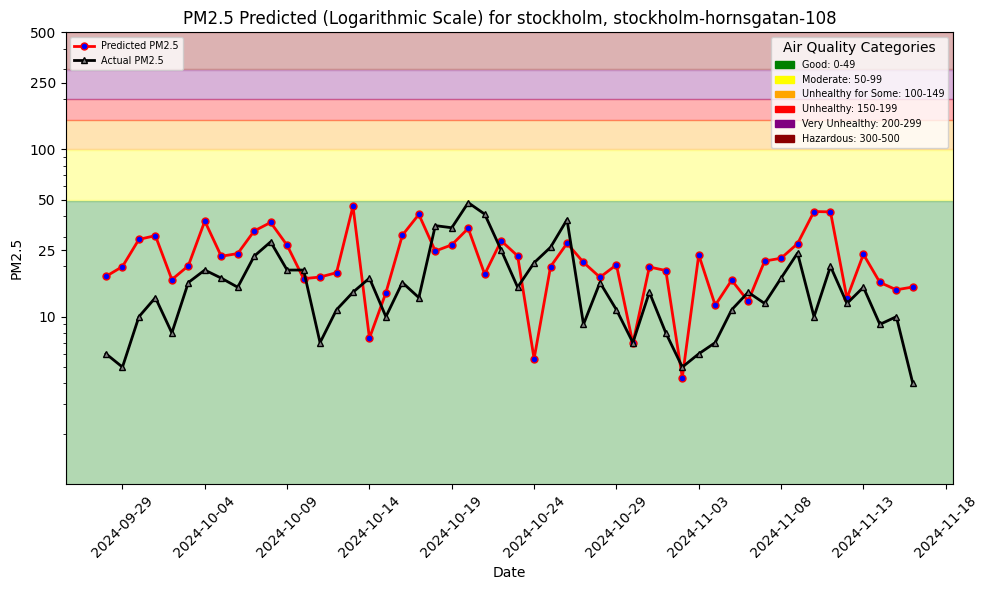

In [32]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

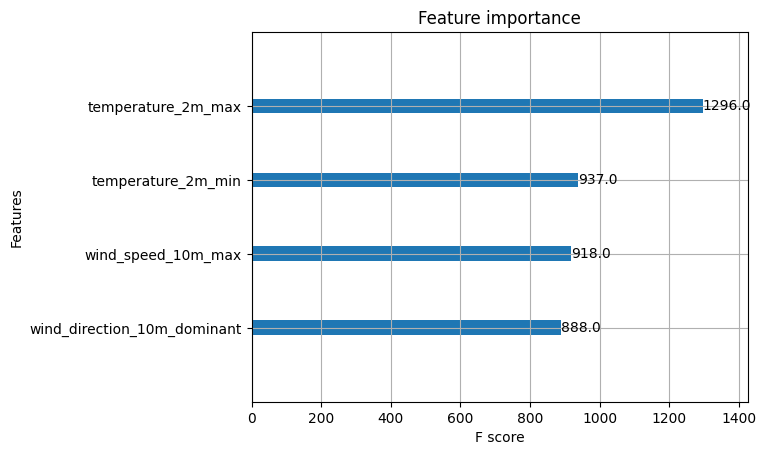

In [33]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### 3.7 Save the model

In [34]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [35]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [36]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [37]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/518459 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48951 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19737 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45041 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/95554 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/117 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/657 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1170583/models/air_quality_xgboost_model/5


Model(name: 'air_quality_xgboost_model', version: 5)